In [3]:
import torch
import torch.nn as nn
import skorch
import numpy as np

from torch.autograd import Variable

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from sine_data import train_dataset, valid_dataset

In [16]:
class Clocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh'):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.period = nn.Parameter(torch.ones(hidden_dim))
        self.shift = nn.Parameter(torch.zeros(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def forward(self, x, clock=None, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim)
            h = skorch.utils.to_var(h, x.is_cuda)
            
        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = (torch.sin(ti/self.period * np.pi + self.shift) + 1) / 2
            # enable stacking of clocking functions
            if clock is not None:
                clock_gate = (clock_gate + clock[ti]) / 2

            h_new = self.i2h(x[:, ti]) + self.h2h(h)
            y = clock_gate * h_new + (1 - clock_gate) * h
            y = self.act(y)
            h = y
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [17]:
import visdom
vis = visdom.Visdom()

In [18]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [19]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [35]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, act='tanh', two_layer=False):
        super().__init__()
        
        self.rnn0 = Clocking(         1, num_hidden, act=act)
        self.rnn1 = Clocking(num_hidden, num_hidden, act=act)
        
        self.two_layer = two_layer

        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0, c0 = self.rnn0(x)
        vis.heatmap(skorch.utils.to_numpy(l0[0]), opts={'title': 'act rnn0'}, win="act rnn0")
        vis.heatmap(skorch.utils.to_numpy(self.rnn0.period).reshape(1, -1), opts={'title': 'periods rnn0'}, win="periods rnn0")
        vis.heatmap(skorch.utils.to_numpy(self.rnn0.shift).reshape(1, -1), opts={'title': 'shifts rnn0'}, win="shifts rnn0")
        vis.heatmap(skorch.utils.to_numpy(c0), opts={'title': 'clock rnn0'}, win="clock rnn0")
        
        if self.two_layer:
            l1, h1, c1 = self.rnn1(l0, clock=c0)
            vis.heatmap(skorch.utils.to_numpy(l1[0]), opts={'title': 'act rnn1'}, win="act rnn1")
            vis.heatmap(skorch.utils.to_numpy(self.rnn1.period).reshape(1, -1), opts={'title': 'periods rnn1'}, win="periods rnn1")
            vis.heatmap(skorch.utils.to_numpy(self.rnn1.shift).reshape(1, -1), opts={'title': 'shifts rnn1'}, win="shifts rnn1")
            vis.heatmap(skorch.utils.to_numpy(c1), opts={'title': 'clock rnn1'}, win="clock rnn1")
        else:
            l1 = l0

        l1 = self.clf(time_flatten(l1))
        return time_unflatten(l1, x.size())

In [36]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss,
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, training=training)

In [40]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.02,
             max_epochs=40,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__act='relu',
             module__two_layer=True,
             use_cuda=False,
            )

In [41]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0033        0.7102  0.2972
      2        0.7154        0.4161  0.2887
      3        0.4262        0.1408  0.2889
      4        0.1761        0.0987  0.3059
      5        0.1827        0.1941  0.3291
      6        0.2358        0.0268  0.3468
      7        0.0745        0.0938  0.3110
      8        0.1279        0.0672  0.3353
      9        0.0857        0.0930  0.3025
     10        0.1007        0.0456  0.3108
     11        0.0577        0.0285  0.3219
     12        0.0484        0.0358  0.2971
     13        0.0578        0.0111  0.2862
     14        0.0279        0.0340  0.2915
     15        0.0445        0.0205  0.2913
     16        0.0304        0.0116  0.3068
     17        0.0264        0.0110  0.3651
     18        0.0246        0.0077  0.2898
     19        0.0162        0.0151  0.2854
     20        0.0211        0.0080

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): Clocking(
      (i2h): Linear(in_features=1, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (rnn1): Clocking(
      (i2h): Linear(in_features=16, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (clf): Linear(in_features=16, out_features=1)
  ),
)

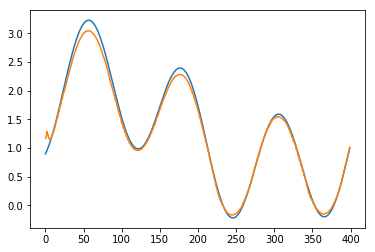

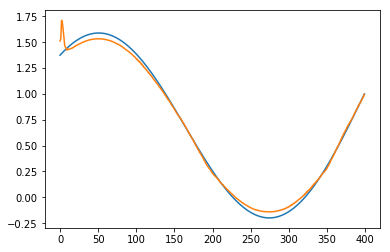

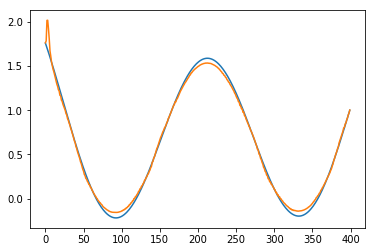

In [42]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])